<a href="https://colab.research.google.com/github/Nevermetyou65/PyTorch-Exercises/blob/main/LeNet_with_CIFAR10_with_hyper_params_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

convoluational filter, kernel, kernel matrix -> small in spatial dimensionality -> ***feature detector***<br>
เลื่อน kernel ไปเท่าไหร่ เรียกว่า ***stride***<br>
ที่ที่ operation take place -> ***receptive field***<br>
คูณค่า pixel กับ ค่าใน kernel -> บวกกัน -> หารจำนวน cells(pixels) ใน receptive field
สิ่งที่ได้เรียกว่า ***feature map*** <br>
kernel จะต้องถูกเทรน depth ของ kernel จะต้อง match image channel<br>
feature map stack along the depth -> put in ***ReLu*** (introduce non-linearity)

Model modification for hyper-params tuning
1. Learning rate
2. add more Convoluational Layer -> double the depth of the  output of preceding layer (แล้วก็ ถ้าลดขนาด kernel จะช่วยลด overfit) จะช่วย extract features ได้ดีขึ้นทำให้ acc ดีขึ้น <br>
note: เวลาทำ cnn เนี่ย depth ของ featuremap ควรออกแบบให้เพิ่มขึ้นตลอดเวลาผ่าน conv ไป<br>
note2: เวลาเจอ complex data ใส่ padding เข้าไปด้วยก็ดี (preserve edge pixels)
3. data augmentation -> allow model to view in "variety" of prespective

In [ ]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
import torch.nn.functional as F

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
transform_train = transforms.Compose([
                                transforms.Resize((32, 32)),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(10),
                                transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
                                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),      
                                transforms.ToTensor(), # ToTensor() เปลี่ยนจาก range 0-255 เป็น 0-1
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # iamge range -1 to 1

transform = transforms.Compose([transforms.Resize((32, 32)),
                                transforms.ToTensor(), # ToTensor() เปลี่ยนจาก range 0-255 เป็น 0-1
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # iamge range -1 to 1

In [ ]:
training_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_train)
validation_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
# ตรง root นี้ เอาไปใส่ไว้ที่เดียวกันก็ได้ ทั้ง train และ val
training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=100, shuffle=False) # เอามาvalidateไม่ต้อง shuffle

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
def image_convert(tensor):
    image = tensor.cpu().clone().detach().numpy() #dim -> 1,28,28
    image = image.transpose(1, 2, 0) # เหมือนกับว่าก่อนหน้านี้มันเป็น C,H,W  แต่เราต้องใช้เป็น C อยู่หลังสุด -> 28,28,1
    # print(image.shape)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5,0.5,0.5))
    # image = image[:,:,0]
    # image = np.squeeze(image, axis=2)
    image = np.reshape(image, (32, 32, 3))
    # print("new shape:", image.shape)
    image = image.clip(0, 1)
    return image

In [ ]:
classes = ("plane", "car", "bird", "cat", "deer", " dog", "frog", "horse", "ship", "truck")
print(len(classes))

10


In [ ]:
print(training_dataset)
print(validation_dataset)

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               RandomAffine(degrees=[0.0, 0.0], scale=(0.8, 1.2), shear=[-10.0, 10.0])
               ColorJitter(brightness=[0.8, 1.2], contrast=[0.8, 1.2], saturation=[0.8, 1.2], hue=None)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


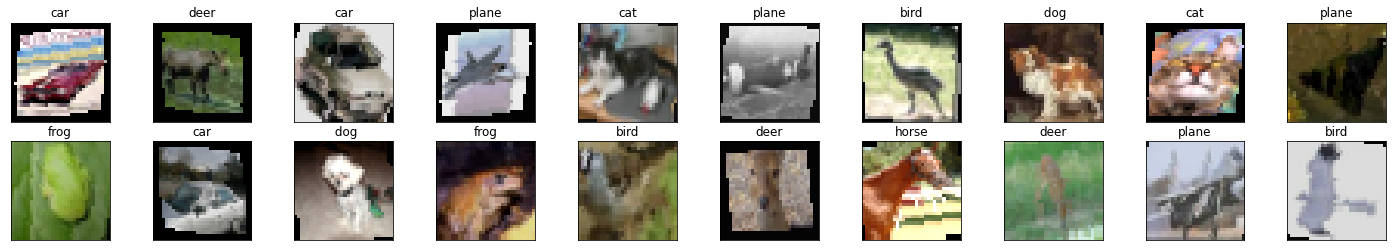

In [ ]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(image_convert(images[idx]))
    ax.set_title(classes[labels[idx].item()])

In [ ]:
print(images.shape)
print(images.view(images.shape[0], -1).shape)
print(labels.size())
print(labels)

torch.Size([100, 3, 32, 32])
torch.Size([100, 3072])
torch.Size([100])
tensor([1, 4, 1, 0, 3, 0, 2, 5, 3, 0, 6, 1, 5, 6, 2, 4, 7, 4, 0, 2, 4, 3, 8, 9,
        5, 8, 5, 0, 7, 3, 0, 0, 9, 7, 9, 6, 7, 4, 3, 2, 5, 4, 6, 2, 8, 4, 3, 1,
        1, 1, 5, 8, 8, 8, 0, 4, 3, 3, 6, 1, 5, 6, 0, 7, 6, 9, 2, 2, 9, 2, 2, 7,
        3, 2, 2, 8, 0, 3, 7, 0, 1, 9, 8, 1, 3, 3, 3, 6, 2, 5, 0, 4, 3, 8, 2, 4,
        5, 1, 3, 1])


In [ ]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, 1, padding=1) # inputchannel, outputchannel(จำนวน featuremap น่าจะเท่ากับจำนวน kernel), ขนาด filter, stride 1ก็พอ ถ้ามากไปอาจจะไม่ดี
        self.conv2 = nn.Conv2d(16, 32, 3, 1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, 1, padding=1)

        self.fc1 = nn.Linear(4*4*64, 500) 
        self.dropout1 = nn.Dropout(0.5) # ปกติวาง dropout ไว้ระหว่าง layer ที่จำนวน parameters เยอะๆ
        self.fc2 = nn.Linear(500, 10) # layer2(output) มี 10 nodes   
    def forward(self, x):
        x = F.relu(self.conv1(x)) #** รับ input ที่ต้องนี้แทนที่ __init__ **
        x = F.max_pool2d(x, 2, 2) # 2, 2 นี่คือขนาด kernel 2x2 in this case

        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)

        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2, 2)

        x = x.view(-1, 4*4*64) #-1 นี่น่าจะให้โปรแกรมมันใส่ batch size เอง/ 4*4*50 เนี่ยกลับไปดูที่ self.fc1 ก็น่าจะเดาได้ # Flatten
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.fc2(x) # จะได้เอาไปใส่ใน crossentropy / ได้ scores
        return x

In [ ]:
model = LeNet().to(device) # D_out ตาม class ที่เราจะ predict # ไอ .to() เนี่ยใส่ที model + tensor ที่เข้า model รวมถึงตอน predict แค่เพื่อให้เราใช้ GPU ได้เฉยๆ
model

LeNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # complex dataset -> more efficient lr

In [ ]:
epochs = 15
running_loss_history = []
running_correct_history = []
val_running_loss_history = []
val_running_correct_history = []

for e in range(epochs):

    running_loss = 0.0
    running_correct = 0.0
    val_running_loss = 0.0
    val_running_correct = 0.0
    for inputs, labels in training_loader: #  ออกมาที 100 ภาพ 100 labels
        inputs = inputs.to(device)
        labels = labels.to(device)
        # inputs = inputs.view(inputs.shape[0], -1) #  -1 คือให้เป็น one long vector # พอมาใช้  CNN ไม่ต้องเปลี่ยนแล้ว ใส่ไปเป็นภาพได้เลย
        outputs = model(inputs) #  ใช้งานแบบนี้ได้เลย จริงไปอ่านมาว่าเราไม่ควรใช้ .forward / บรรทัดนี้ก็น่าจะออกมาเป็น tensor size=100
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1) # preds นี้คือ index ซึ่งสอดคล้องกับ ชื่อภาพ /  _ คือค่าmax แต่เราไม่ได้สนใจค่าเราสนใจ index ของมัน
        running_correct += torch.sum(preds == labels.data) # ตัวเศษของค่าเฉลี่ย
        running_loss += loss.item()
    else:
        with torch.no_grad(): # set requie_grad to False -> เพราะว่าเราไม่ได้จะ train model ใหม่ ทำแบบนี้จะช่วย save memory 
            for val_inputs, val_labels in validation_loader:
                val_inputs = val_inputs.to(device)
                val_labels = val_labels.to(device)
                # val_inputs = val_inputs.view(val_inputs.shape[0], -1) #  -1 คือให้เป็น one long vector
                val_outputs = model(val_inputs) #  ใช้งานแบบนี้ได้เลย จริงไปอ่านมาว่าเราไม่ควรใช้ .forward / บรรทัดนี้ก็น่าจะออกมาเป็น tensor size=100
                val_loss = criterion(val_outputs, val_labels)

                _, val_preds = torch.max(val_outputs, 1) 
                val_running_correct += torch.sum(val_preds == val_labels.data)
                val_running_loss += val_loss.item()

        epoch_loss = running_loss / len(training_loader)
        epoch_acc = running_correct.float() / len(training_loader)
        running_loss_history.append(epoch_loss)
        running_correct_history.append(epoch_acc)

        val_epoch_loss = val_running_loss / len(validation_loader)
        val_epoch_acc = val_running_correct.float() / len(validation_loader)
        val_running_loss_history.append(val_epoch_loss)
        val_running_correct_history.append(val_epoch_acc)
        print("Epoch:", e+1)
        print("training loss: {:.4f}, acc:{:.4f}".format(epoch_loss, epoch_acc))
        print("validation loss: {:.4f}, val acc:{:.4f}".format(val_epoch_loss, val_epoch_acc))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 1
training loss: 1.6964, acc:37.7140
validation loss: 1.3874, val acc:49.1800
Epoch: 2
training loss: 1.3949, acc:49.4440
validation loss: 1.2236, val acc:55.8900
Epoch: 3
training loss: 1.2585, acc:54.6260
validation loss: 1.1218, val acc:59.8300
Epoch: 4
training loss: 1.1744, acc:58.3240
validation loss: 1.0644, val acc:62.2100
Epoch: 5
training loss: 1.1023, acc:60.6040
validation loss: 1.0432, val acc:63.0000
Epoch: 6
training loss: 1.0522, acc:62.7500
validation loss: 0.9613, val acc:66.8200
Epoch: 7
training loss: 1.0057, acc:64.2160
validation loss: 0.9184, val acc:67.6600
Epoch: 8
training loss: 0.9758, acc:65.4020
validation loss: 0.8943, val acc:68.9600
Epoch: 9
training loss: 0.9490, acc:66.5980
validation loss: 0.8594, val acc:70.0000
Epoch: 10
training loss: 0.9198, acc:67.6680
validation loss: 0.8541, val acc:70.1900
Epoch: 11
training loss: 0.9036, acc:68.4220
validation loss: 0.8436, val acc:70.7800
Epoch: 12
training loss: 0.8819, acc:69.0160
validation loss: 0

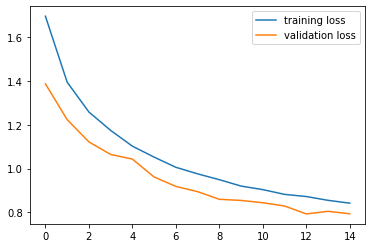

In [ ]:
plt.plot(running_loss_history, label="training loss")
plt.plot(val_running_loss_history, label="validation loss")
plt.legend()
plt.show()

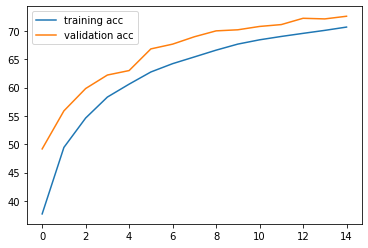

In [ ]:
plt.plot(running_correct_history, label="training acc")
plt.plot(val_running_correct_history, label="validation acc")
plt.legend()
plt.show()

<Response [200]>
format: JPEG


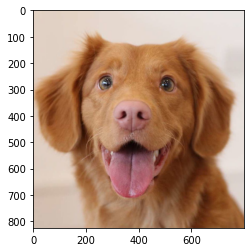

In [ ]:
import requests
from PIL import Image, ImageOps
url = "https://post.medicalnewstoday.com/wp-content/uploads/sites/3/2020/02/322868_1100-800x825.jpg"
response = requests.get(url, stream=True)
print(response)

img = Image.open(response.raw)
print("format:", img.format)
plt.imshow(img)

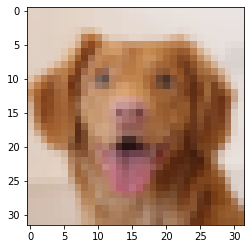

In [ ]:
img = transform(img)
plt.imshow(image_convert(img))

In [ ]:
# img.shape
# img
print("shape of img:", img.shape)

shape of img: torch.Size([3, 32, 32])


In [ ]:
img = img.to(device).unsqueeze(0)
print("shape of img now:", img.shape)
output = model(img)
print("Score output from model:", output)
_, pred = torch.max(output, 1)
print("===============================================")
print("Prediction of this image:", classes[pred]) # หลังจาก tuning ตอนนี้ทายถูกแล้ว แต่ว่าจริง acc มันยังไม่ค่อยโอเค

shape of img now: torch.Size([1, 3, 32, 32])
Score output from model: tensor([[-7.2935, -6.2872,  0.0779,  2.3665, -1.1476,  2.8950,  1.0394, -0.9576,
         -5.8791, -1.0189]], device='cuda:0', grad_fn=<AddmmBackward>)
Prediction of this image:  dog


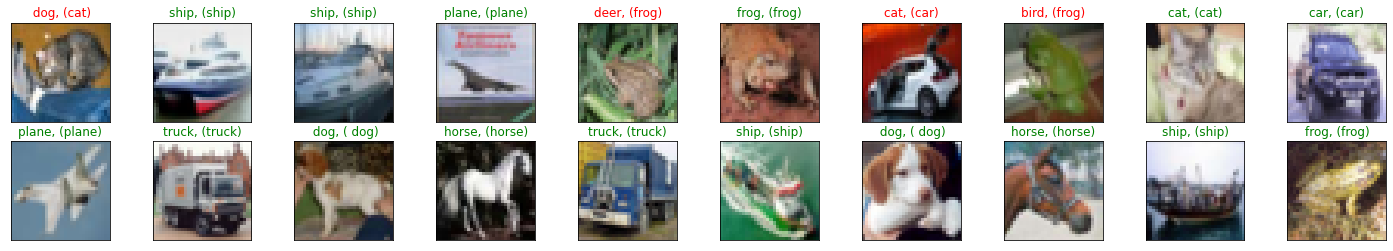

In [ ]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
output = model(images)
_, pred = torch.max(output, 1)
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(image_convert(images[idx]))
    ax.set_title("{}, ({})".format(str(classes[pred[idx].item()]), str(classes[labels[idx].item()])), color=("green" if pred[idx] == labels[idx] else "red"))